# Seismic Signal Processing ToolBox
Created on: 26/08/2021

Updated on: 18/07/2022

Author: Volkan Ozsarac

Affiliation: University School for Advanced Studies IUSS Pavia

Earthquake Engineering PhD Candidate

email:  volkan.ozsarac@iusspavia.it

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')
# Change directory to the location of notebook
%cd /content/drive/My Drive/Colab Notebooks/EzGM/notebooks 
# Install Openquake and EzGM
!pip install --upgrade pip
!pip install git+https://github.com/gem/oq-engine
!pip install git+https://github.com/volkanozsarac/EzGM.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/EzGM/notebooks
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/gem/oq-engine to /tmp/pip-req-build-i88c3w_j
  Running command git clone --filter=blob:none --quiet https://github.com/gem/oq-engine /tmp/pip-req-build-i88c3w_j
  Resolved https://github.com/gem/oq-engine to commit ff38caefb481b02684680719bac106c9aeb70eab
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/volkanozsarac/EzGM.git to /tmp/pip-req-build-s5hfqw4e
  Running command git clone --filter=blob:none --quiet https://github.com/volkanozsarac/EzGM.git /tmp/pip-req-

In [2]:
from EzGM import signal
from EzGM.utility import ReadESM, run_time
from time import time
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
# Acquire the run start time
start_time = time()

## 1) Read the record

In [4]:
parent_path = os.path.dirname(os.path.realpath(""))
gm_path1 = os.path.join(parent_path, 'input files', '19991112165722_1401_mp_RawAcc_E.asc')
gm_path2 = os.path.join(parent_path, 'input files', '19991112165722_1401_mp_RawAcc_N.asc')
gm_path3 = os.path.join(parent_path, 'input files', '19991112165722_1401_mp_RawAcc_U.asc')
dt, npts, desc, t, Ag1 = ReadESM(inFilename= gm_path1)
dt, npts, desc, t, Ag2 = ReadESM(inFilename= gm_path2)
dt, npts, desc, t, Ag3 = ReadESM(inFilename= gm_path3)

## 2) Process the record

In [5]:
# Apply baseline correction
Ag1_corrected = signal.baseline_correction(Ag1, dt, polynomial_type='Linear')
Ag2_corrected = signal.baseline_correction(Ag2, dt, polynomial_type='Linear')
Ag3_corrected = signal.baseline_correction(Ag3, dt, polynomial_type='Linear')

# Apply band-pass filtering
Ag1_filtered = signal.butterworth_filter(Ag1_corrected, dt, cut_off=(0.1, 25), filter_order=4, filter_type='bandpass')
Ag2_filtered = signal.butterworth_filter(Ag2_corrected, dt, cut_off=(0.1, 25), filter_order=4, filter_type='bandpass')
Ag3_filtered = signal.butterworth_filter(Ag3_corrected, dt, cut_off=(0.1, 25), filter_order=4, filter_type='bandpass')

# Linear elastic analysis of a single degree of freedom system
u1, v1, ac1, ac_tot1 = signal.sdof_ltha(Ag1_filtered, dt, T = 1.0, xi = 0.05)
u2, v2, ac2, ac_tot2 = signal.sdof_ltha(Ag2_filtered, dt, T = 1.0, xi = 0.05)
u3, v3, ac3, ac_tot3 = signal.sdof_ltha(Ag3_filtered, dt, T = 1.0, xi = 0.05)

# Calculate ground motion parameters
param1 = signal.get_parameters(Ag1_filtered, dt, T = np.arange(0,4.05,0.05), xi = 0.05)
param2 = signal.get_parameters(Ag2_filtered, dt, T = np.arange(0,4.05,0.05), xi = 0.05)
param3 = signal.get_parameters(Ag3_filtered, dt, T = np.arange(0,4.05,0.05), xi = 0.05)

# Obtain RotDxx Spectrum
Periods, Sa_RotDxx = signal.RotDxx_spectrum(Ag1_filtered, Ag2_filtered, dt, T = np.arange(0,4.05,0.05), xi = 0.05, xx = [0, 50, 100])

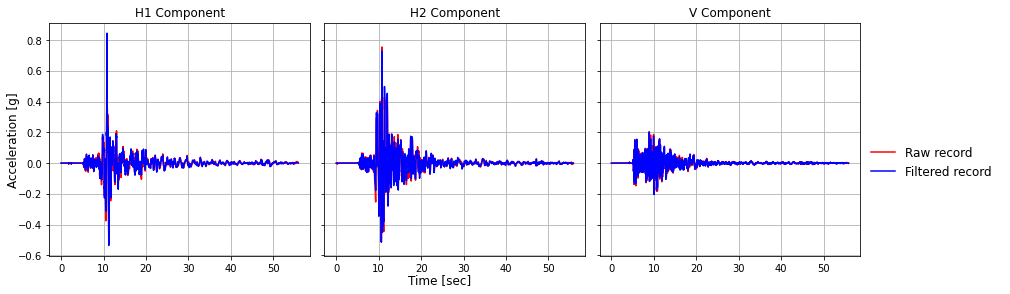

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,4))
axs[0].plot(t, Ag1, label='Raw record', color='red')
axs[0].plot(t, Ag1_filtered, label='Filtered record', color='blue')
axs[0].grid(True)
axs[0].set_title('H1 Component')
axs[1].plot(t, Ag2, color='red')
axs[1].plot(t, Ag2_filtered, color='blue')
axs[1].grid(True)
axs[1].set_title('H2 Component')
axs[2].plot(t, Ag3, color='red')
axs[2].plot(t, Ag3_filtered, color='blue')
axs[2].grid(True)
axs[2].set_title('V Component')

fig.text(0.5, 0.0, 'Time [sec]', ha='center', fontsize=12)
fig.text(0.0, 0.5, 'Acceleration [g]', va='center', rotation='vertical', fontsize=12)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.66, 0.05, 0.5, 0.5), fontsize=12, frameon=False)
plt.tight_layout()

(0.05, 4.0)

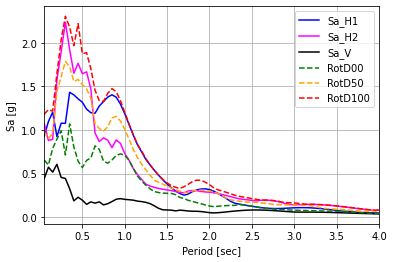

In [7]:
plt.figure()
plt.plot(param1['Periods'], param1['PSa'], label='Sa_H1', color = 'blue')
plt.plot(param2['Periods'], param2['PSa'], label='Sa_H2', color = 'magenta')
plt.plot(param3['Periods'], param3['PSa'], label='Sa_V', color = 'black')
plt.plot(Periods, Sa_RotDxx[0], label='RotD00', ls='--', color = 'green')
plt.plot(Periods, Sa_RotDxx[1], label='RotD50', ls='--', color = 'orange')
plt.plot(Periods, Sa_RotDxx[2], label='RotD100', ls='--', color = 'red')
plt.legend()
plt.grid(True)
plt.xlabel('Period [sec]')
plt.ylabel('Sa [g]')
plt.xlim([Periods[0],Periods[-1]])

In [8]:
# Calculate the total time passed
run_time(start_time)

Run time: 0 hours: 0 minutes: 7.43 seconds
